In [1]:
import random
import numpy as np

In [2]:
def get_size_a():
    size_a = [14,100,40,4]
    return size_a
    
def get_size_b():
    size_b = [14]
    for i in range(6):
        size_b.append(28)
    size_b.append(4)
    return size_b

def get_size_c():
    size_c = [14]
    for i in range(28):
        size_c.append(14)
    size_c.append(4)
    return size_c

In [3]:
# eg. a_list[-1] = convert_to_hot_vector(np.argmax(a_list[-1]), 4)
def convert_to_hot_vector(y, num_class):
    v = np.zeros(num_class)
    v[y] = 1
    v.shape = (num_class,1)
    return v

# eg. convert_to_hot_vectors(np.array([1, 0, 3]), 4)
def convert_to_hot_vectors(y_s, num_class):
    m = np.zeros((y_s.size, num_class))
    m[np.arange(y_s.size), y_s] = 1
    return m

In [4]:
def relu(x):
    r = x * (x > 0)
    r.shape = x.shape
    return r

def relu_derivative(x):
    d = np.array([1 if i>0 else 0 for i in x])
    d.shape = x.shape
    return d 

def softmax(x):
    """Compute softmax values for each value in x. Minus max to avoid large values in intermidiate steps"""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def cross_entropy(o,y):
    return -np.sum(np.multiply(y, np.log(o)))

In [ ]:
def check_shape(list_of_arrays):
    shapes = [b.shape for b in list_of_arrays]
    print(shapes)

In [5]:
class Network(object):
    def __init__(self, sizes, initial_b=None, initial_w=None):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = initial_b if initial_b else [np.random.random((y,1)) - 0.5 for y in sizes[1:]]
        self.weights = initial_w if initial_w else [np.random.random((y,x)) - 0.5 for x, y in zip(sizes[:-1], sizes[1:])]
        
    def feedforward(self, a):
        for b, w in zip(self.biases[0:-1], self.weights[0:-1]):
            a = relu(np.dot(w,a) + b)
        z = np.dot(self.weights[-1], a) + self.biases[-1]
        a = softmax(z)
        return a
    
    def stochastic_gradient_descent(self, training_data, iterations, mini_batch_size, learning_rate, test_data=None):
        """training_data is a list of tupes (x,y). ''test_data'' is used for cost & accuracy evaluation"""
        n = len(training_data)
        training_cost = np.zeros(iterations)
        test_cost = np.zeros(iterations)
        training_accuracy = np.zeros(iterations)
        test_accuracy = np.zeros(iterations)
        for i in range(iterations):
            # evaluate cost & accuracy for training data and test data
            training_cost[i], training_accuracy[i] = self.evaluate(training_data)
            print("Iter", i,": TrC: ", training_cost[i], "; TrA: ",training_accuracy[i])
            if test_data:
                test_cost[i], test_accuracy[i] = self.evaluate(test_data)
                print("Iter ", i,": TeC: ", test_cost[i], "; TeA: ", test_accuracy[i])
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_weights_biases(mini_batch, learning_rate)
        return (training_cost, training_accuracy, test_cost, test_accuracy)
    
    def update_weights_biases(self, mini_batch, learning_rate):
        """The ``mini_batch`` is a list of tuples ``(x, y)``."""
        sum_gradients_b = [np.zeros(b.shape) for b in self.biases]
        sum_gradients_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            gradients_b, gradients_w = self.backpropagate(x, y)
            sum_gradients_b = [sum_gb + gb for sum_gb, gb in zip(sum_gradients_b, gradients_b)]
            sum_gradients_w = [sum_gw + gw for sum_gw, gw in zip(sum_gradients_w, gradients_w)]
        self.biases = [b - learning_rate/len(mini_batch)*gb for b, gb in zip(self.biases, sum_gradients_b)]
        self.weights = [w - learning_rate/len(mini_batch)*gw for w, gw in zip(self.weights, sum_gradients_w)]
    
    def backpropagate(self, x, y):
        gradients_b = [np.zeros(b.shape) for b in self.biases]
        gradients_w = [np.zeros(w.shape) for w in self.weights]
        #feedforward
        a = x
        a_list = [x]
        z_list = []
        for b, w in zip(self.biases[0:-1], self.weights[0:-1]):
            z = np.dot(w, a) + b
            a = relu(z)
            a_list.append(a)
            z_list.append(z)
        z = np.dot(self.weights[-1], a_list[-1]) + self.biases[-1]
        a = softmax(z)
        a_list.append(a)
        z_list.append(z)
        # backward
        # for softmax-cross-entropy layer: delta in last layer = result - ground truth
        delta = a_list[-1] - y
        # update b and w for the last layer L
        gradients_b[-1] = delta
        gradients_w[-1] = np.dot(delta, a_list[-2].transpose())
        # update b and w for the rest of layers L-1, L-2, ... 
        for l in range(2, self.num_layers):
            z = z_list[-l]  # lth last layer of z
            r_derivative = relu_derivative(z)
            # update delta based on delta(l) = transpose of w(l+1) * delta(l+1)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * r_derivative
            gradients_b[-l] = delta
            gradients_w[-l] = np.dot(delta, a_list[-l-1].transpose())
        return (gradients_b, gradients_w)
    
    def evaluate(self, data):
        output = [self.feedforward(x) for x, y in data]
        cost = [cross_entropy(o, d[1]) for o, d in zip(output, data)]
        results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in data]
        accuracy = sum(int(x == y) for (x, y) in results)/len(results)
        avg_cost = sum(cost)/len(cost)
        return (avg_cost, accuracy)

    

In [6]:
from numpy import genfromtxt
import os

# prepare data
userhome = os.path.expanduser('~')
shared_path = userhome + r'/Downloads/assignment1/Question2_123'
path_training_x = 'x_train.csv'
path_training_y = 'y_train.csv'
path_test_x = 'x_test.csv'
path_test_y = 'y_test.csv'
training_X =  genfromtxt(os.path.join(shared_path, path_training_x),delimiter=",")
training_Y =  genfromtxt(os.path.join(shared_path, path_training_y),delimiter=",")
training_data = [(x.reshape(14,1), convert_to_hot_vector(int(y),4)) for x, y in zip(training_X,training_Y)]
test_X =  genfromtxt(os.path.join(shared_path, path_test_x),delimiter=",")
test_Y =  genfromtxt(os.path.join(shared_path, path_test_y),delimiter=",")
test_data = [(x.reshape(14,1), convert_to_hot_vector(int(y),4)) for x, y in zip(test_X, test_Y)]

In [7]:
%matplotlib inline 
import matplotlib.pyplot as plt

def save_to_file(title, training_cost, training_accuracy, test_cost, test_accuracy):
    userhome = os.path.expanduser('~')
    path = userhome + r'/Downloads/e0047338/toDelete'
    filename = os.path.join(path, title + '.txt')
    np.savetxt(filename, (training_cost, training_accuracy,test_cost,test_accuracy), delimiter=',', fmt='%1.4f')
    
def plot_graph(title, y_1, y_2, size, label_1, label_2, x_label, y_label):
    plt.figure(figsize=(15,7))
    plt.title(title)
    plt.plot(np.arange(0, size, 1), y_1, 'o-', label = label_1)
    plt.plot(np.arange(0, size, 1), y_2, 'o-', label = label_2)
    plt.grid() 
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    plt.legend(loc='best', fontsize=16)

def plot_graph(title, y_1, y_2, size, label_1, label_2, x_label, y_label, y_lim):
    plt.figure(figsize=(15,7))
    plt.title(title)
    plt.plot(np.arange(0, size, 1), y_1, 'o-', label = label_1)
    plt.plot(np.arange(0, size, 1), y_2, 'o-', label = label_2)
    plt.grid() 
    plt.ylim(y_lim)
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    plt.legend(loc='best', fontsize=16)

network_a = Network(get_size_a())
training_cost, training_accuracy, test_cost, test_accuracy = network_a.stochastic_gradient_descent(training_data, 1000, 100, 0.1, test_data)

Iter 0 : TrC:  4.16961290258 ; TrA:  0.273594262608
Iter  0 : TeC:  4.17292977567 ; TeA:  0.26579188282
Iter 1 : TrC:  0.796418053586 ; TrA:  0.638361181048
Iter  1 : TeC:  0.820730077211 ; TeA:  0.629539212695
Iter 2 : TrC:  0.804078315229 ; TrA:  0.636530098421
Iter  2 : TeC:  0.838954915558 ; TeA:  0.62160512664
Iter 3 : TrC:  0.433143454868 ; TrA:  0.811093308919
Iter  3 : TeC:  0.459817140437 ; TeA:  0.797680805615
Iter 4 : TrC:  1.26335620404 ; TrA:  0.621347371633
Iter  4 : TeC:  1.33951913487 ; TeA:  0.612450411962
Iter 5 : TrC:  0.790283652259 ; TrA:  0.712596322576
Iter  5 : TeC:  0.88205295194 ; TeA:  0.685993286543
Iter 6 : TrC:  0.566527537353 ; TrA:  0.784161135271
Iter  6 : TeC:  0.644432740665 ; TeA:  0.769301190113
Iter 7 : TrC:  0.880923865933 ; TrA:  0.720683604181
Iter  7 : TeC:  0.959920603664 ; TeA:  0.712236801953
Iter 8 : TrC:  0.557125051331 ; TrA:  0.806820782788
Iter  8 : TeC:  0.621305163355 ; TeA:  0.789441562405
Iter 9 : TrC:  1.05407920879 ; TrA:  0.71839

Iter  76 : TeC:  0.0664679566944 ; TeA:  0.974671956057
Iter 77 : TrC:  0.00467387316466 ; TrA:  1.0
Iter  77 : TeC:  0.0689035014248 ; TeA:  0.974061641745
Iter 78 : TrC:  0.00437822978508 ; TrA:  1.0
Iter  78 : TeC:  0.0685557931977 ; TeA:  0.976197741837
Iter 79 : TrC:  0.0264177989356 ; TrA:  0.990997177081
Iter  79 : TeC:  0.138372501536 ; TeA:  0.953921269454
Iter 80 : TrC:  0.00420134732018 ; TrA:  1.0
Iter  80 : TeC:  0.068215495574 ; TeA:  0.975587427525
Iter 81 : TrC:  0.0153977154266 ; TrA:  0.995803768978
Iter  81 : TeC:  0.0890334503128 ; TeA:  0.966127555691
Iter 82 : TrC:  0.00367576220383 ; TrA:  1.0
Iter  82 : TeC:  0.0622677221835 ; TeA:  0.977113213305
Iter 83 : TrC:  0.00330142121779 ; TrA:  1.0
Iter  83 : TeC:  0.0659819760364 ; TeA:  0.973451327434
Iter 84 : TrC:  0.0033180044651 ; TrA:  1.0
Iter  84 : TeC:  0.0603630301108 ; TeA:  0.977723527617
Iter 85 : TrC:  0.00338049539761 ; TrA:  1.0
Iter  85 : TeC:  0.0644497448914 ; TeA:  0.976808056149
Iter 86 : TrC:  0.

Iter  156 : TeC:  0.0581096265573 ; TeA:  0.979859627708
Iter 157 : TrC:  0.00105611576302 ; TrA:  1.0
Iter  157 : TeC:  0.0578813326415 ; TeA:  0.979859627708
Iter 158 : TrC:  0.00100624171012 ; TrA:  1.0
Iter  158 : TeC:  0.0568109537355 ; TeA:  0.979859627708
Iter 159 : TrC:  0.00100417064842 ; TrA:  1.0
Iter  159 : TeC:  0.056538364256 ; TeA:  0.979249313396
Iter 160 : TrC:  0.000999082198895 ; TrA:  1.0
Iter  160 : TeC:  0.0560900476211 ; TeA:  0.98046994202
Iter 161 : TrC:  0.00113122401028 ; TrA:  1.0
Iter  161 : TeC:  0.0581465356938 ; TeA:  0.978028684773
Iter 162 : TrC:  0.000978746563019 ; TrA:  1.0
Iter  162 : TeC:  0.0552493548745 ; TeA:  0.98046994202
Iter 163 : TrC:  0.000974725366993 ; TrA:  1.0
Iter  163 : TeC:  0.0557614787072 ; TeA:  0.980775099176
Iter 164 : TrC:  0.000961932857472 ; TrA:  1.0
Iter  164 : TeC:  0.0560356117461 ; TeA:  0.980164784864
Iter 165 : TrC:  0.000965471699972 ; TrA:  1.0
Iter  165 : TeC:  0.0568190366301 ; TeA:  0.981080256332
Iter 166 : TrC

Iter 236 : TrC:  0.000560821073846 ; TrA:  1.0
Iter  236 : TeC:  0.0536060473073 ; TeA:  0.981385413488
Iter 237 : TrC:  0.000555398790179 ; TrA:  1.0
Iter  237 : TeC:  0.0535872435629 ; TeA:  0.981690570644
Iter 238 : TrC:  0.000610311778047 ; TrA:  1.0
Iter  238 : TeC:  0.0553637731092 ; TeA:  0.981385413488
Iter 239 : TrC:  0.000548683411467 ; TrA:  1.0
Iter  239 : TeC:  0.0540122740784 ; TeA:  0.982300884956
Iter 240 : TrC:  0.000544769915257 ; TrA:  1.0
Iter  240 : TeC:  0.0537382563992 ; TeA:  0.9819957278
Iter 241 : TrC:  0.000542893530396 ; TrA:  1.0
Iter  241 : TeC:  0.0536550091059 ; TeA:  0.9819957278
Iter 242 : TrC:  0.000543345542212 ; TrA:  1.0
Iter  242 : TeC:  0.0543002457067 ; TeA:  0.981385413488
Iter 243 : TrC:  0.000580207417758 ; TrA:  1.0
Iter  243 : TeC:  0.0541648823388 ; TeA:  0.981385413488
Iter 244 : TrC:  0.000532407946207 ; TrA:  1.0
Iter  244 : TeC:  0.0533789831507 ; TeA:  0.981690570644
Iter 245 : TrC:  0.000532610026178 ; TrA:  1.0
Iter  245 : TeC:  0.0

Iter  315 : TeC:  0.052495324065 ; TeA:  0.9819957278
Iter 316 : TrC:  0.000382596605307 ; TrA:  1.0
Iter  316 : TeC:  0.0531167287438 ; TeA:  0.981385413488
Iter 317 : TrC:  0.000370930061481 ; TrA:  1.0
Iter  317 : TeC:  0.0527882866161 ; TeA:  0.981690570644
Iter 318 : TrC:  0.00037043998178 ; TrA:  1.0
Iter  318 : TeC:  0.0529070971299 ; TeA:  0.982300884956
Iter 319 : TrC:  0.000367225214239 ; TrA:  1.0
Iter  319 : TeC:  0.052529628945 ; TeA:  0.9819957278
Iter 320 : TrC:  0.000365629962668 ; TrA:  1.0
Iter  320 : TeC:  0.0521119691027 ; TeA:  0.9819957278
Iter 321 : TrC:  0.000364520462119 ; TrA:  1.0
Iter  321 : TeC:  0.0525314130496 ; TeA:  0.9819957278
Iter 322 : TrC:  0.000367980483563 ; TrA:  1.0
Iter  322 : TeC:  0.052371457259 ; TeA:  0.981385413488
Iter 323 : TrC:  0.000361880913148 ; TrA:  1.0
Iter  323 : TeC:  0.0523185195116 ; TeA:  0.982300884956
Iter 324 : TrC:  0.00036046008154 ; TrA:  1.0
Iter  324 : TeC:  0.0524842093294 ; TeA:  0.982300884956
Iter 325 : TrC:  0.0

Iter 395 : TrC:  0.000277275844903 ; TrA:  1.0
Iter  395 : TeC:  0.0514799949642 ; TeA:  0.982300884956
Iter 396 : TrC:  0.000277526731547 ; TrA:  1.0
Iter  396 : TeC:  0.0513049614285 ; TeA:  0.9819957278
Iter 397 : TrC:  0.000277330981231 ; TrA:  1.0
Iter  397 : TeC:  0.0520629282504 ; TeA:  0.9819957278
Iter 398 : TrC:  0.000279964406482 ; TrA:  1.0
Iter  398 : TeC:  0.0513723969005 ; TeA:  0.9819957278
Iter 399 : TrC:  0.000275507671561 ; TrA:  1.0
Iter  399 : TeC:  0.0519857443845 ; TeA:  0.9819957278
Iter 400 : TrC:  0.000274362278678 ; TrA:  1.0
Iter  400 : TeC:  0.0516495723368 ; TeA:  0.982606042112
Iter 401 : TrC:  0.000271724782256 ; TrA:  1.0
Iter  401 : TeC:  0.0512666654214 ; TeA:  0.982300884956
Iter 402 : TrC:  0.000270516365329 ; TrA:  1.0
Iter  402 : TeC:  0.0519367023314 ; TeA:  0.9819957278
Iter 403 : TrC:  0.000269349012414 ; TrA:  1.0
Iter  403 : TeC:  0.0516742073334 ; TeA:  0.982606042112
Iter 404 : TrC:  0.000269214530384 ; TrA:  1.0
Iter  404 : TeC:  0.0521620

Iter  474 : TeC:  0.051144801516 ; TeA:  0.983216356424
Iter 475 : TrC:  0.000217302238504 ; TrA:  1.0
Iter  475 : TeC:  0.0511832185072 ; TeA:  0.982911199268
Iter 476 : TrC:  0.000216633622894 ; TrA:  1.0
Iter  476 : TeC:  0.0513097260333 ; TeA:  0.982911199268
Iter 477 : TrC:  0.00021954354203 ; TrA:  1.0
Iter  477 : TeC:  0.0514906114932 ; TeA:  0.9819957278
Iter 478 : TrC:  0.000220428245928 ; TrA:  1.0
Iter  478 : TeC:  0.0509626833462 ; TeA:  0.982606042112
Iter 479 : TrC:  0.000215234164686 ; TrA:  1.0
Iter  479 : TeC:  0.0510137628191 ; TeA:  0.982606042112
Iter 480 : TrC:  0.000219087272793 ; TrA:  1.0
Iter  480 : TeC:  0.0508302120299 ; TeA:  0.982606042112
Iter 481 : TrC:  0.000214386805338 ; TrA:  1.0
Iter  481 : TeC:  0.0513376308823 ; TeA:  0.9819957278
Iter 482 : TrC:  0.000213282732306 ; TrA:  1.0
Iter  482 : TeC:  0.0512190656682 ; TeA:  0.982300884956
Iter 483 : TrC:  0.000213790598623 ; TrA:  1.0
Iter  483 : TeC:  0.0513393647237 ; TeA:  0.982300884956
Iter 484 : Tr

Iter  553 : TeC:  0.0507934798572 ; TeA:  0.982911199268
Iter 554 : TrC:  0.000179358218033 ; TrA:  1.0
Iter  554 : TeC:  0.0506283386115 ; TeA:  0.982911199268
Iter 555 : TrC:  0.000177675915872 ; TrA:  1.0
Iter  555 : TeC:  0.0506954226385 ; TeA:  0.983216356424
Iter 556 : TrC:  0.000178138906712 ; TrA:  1.0
Iter  556 : TeC:  0.0505879450805 ; TeA:  0.982911199268
Iter 557 : TrC:  0.000177159372925 ; TrA:  1.0
Iter  557 : TeC:  0.0504126181557 ; TeA:  0.983216356424
Iter 558 : TrC:  0.000176487398031 ; TrA:  1.0
Iter  558 : TeC:  0.0508241742934 ; TeA:  0.982606042112
Iter 559 : TrC:  0.00017685923706 ; TrA:  1.0
Iter  559 : TeC:  0.0506572809552 ; TeA:  0.983216356424
Iter 560 : TrC:  0.000176199180567 ; TrA:  1.0
Iter  560 : TeC:  0.0508422452192 ; TeA:  0.983216356424
Iter 561 : TrC:  0.000175423356115 ; TrA:  1.0
Iter  561 : TeC:  0.0508415027713 ; TeA:  0.982911199268
Iter 562 : TrC:  0.000175026591323 ; TrA:  1.0
Iter  562 : TeC:  0.0508514311202 ; TeA:  0.982911199268
Iter 563

Iter  632 : TeC:  0.0509454550045 ; TeA:  0.982300884956
Iter 633 : TrC:  0.000151206770126 ; TrA:  1.0
Iter  633 : TeC:  0.0504211357135 ; TeA:  0.982300884956
Iter 634 : TrC:  0.000150359726295 ; TrA:  1.0
Iter  634 : TeC:  0.0506729677159 ; TeA:  0.982300884956
Iter 635 : TrC:  0.00015033419303 ; TrA:  1.0
Iter  635 : TeC:  0.0505798170387 ; TeA:  0.983216356424
Iter 636 : TrC:  0.000149707665823 ; TrA:  1.0
Iter  636 : TeC:  0.050712226842 ; TeA:  0.982606042112
Iter 637 : TrC:  0.000149623687821 ; TrA:  1.0
Iter  637 : TeC:  0.0502348010875 ; TeA:  0.982606042112
Iter 638 : TrC:  0.00015031819436 ; TrA:  1.0
Iter  638 : TeC:  0.0507308755182 ; TeA:  0.982606042112
Iter 639 : TrC:  0.000148645288748 ; TrA:  1.0
Iter  639 : TeC:  0.0506891051255 ; TeA:  0.982606042112
Iter 640 : TrC:  0.00014843062563 ; TrA:  1.0
Iter  640 : TeC:  0.0507836872426 ; TeA:  0.982300884956
Iter 641 : TrC:  0.000147897861585 ; TrA:  1.0
Iter  641 : TeC:  0.0505148739271 ; TeA:  0.982606042112
Iter 642 : 

Iter  711 : TeC:  0.0503099584827 ; TeA:  0.983216356424
Iter 712 : TrC:  0.000129521867018 ; TrA:  1.0
Iter  712 : TeC:  0.0504200975294 ; TeA:  0.982606042112
Iter 713 : TrC:  0.000129238742534 ; TrA:  1.0
Iter  713 : TeC:  0.0502666396372 ; TeA:  0.982606042112
Iter 714 : TrC:  0.000129169436906 ; TrA:  1.0
Iter  714 : TeC:  0.0501527096705 ; TeA:  0.983216356424
Iter 715 : TrC:  0.00012868222239 ; TrA:  1.0
Iter  715 : TeC:  0.0503268637155 ; TeA:  0.982606042112
Iter 716 : TrC:  0.000128456024066 ; TrA:  1.0
Iter  716 : TeC:  0.0503425141476 ; TeA:  0.982300884956
Iter 717 : TrC:  0.000128329717368 ; TrA:  1.0
Iter  717 : TeC:  0.0502581565914 ; TeA:  0.982911199268
Iter 718 : TrC:  0.000128193721771 ; TrA:  1.0
Iter  718 : TeC:  0.0503259384827 ; TeA:  0.982911199268
Iter 719 : TrC:  0.000127829146991 ; TrA:  1.0
Iter  719 : TeC:  0.0503475042706 ; TeA:  0.982300884956
Iter 720 : TrC:  0.000127635808396 ; TrA:  1.0
Iter  720 : TeC:  0.050325270016 ; TeA:  0.982911199268
Iter 721 

Iter  790 : TeC:  0.0500827205912 ; TeA:  0.982606042112
Iter 791 : TrC:  0.000114276672648 ; TrA:  1.0
Iter  791 : TeC:  0.049828944152 ; TeA:  0.982606042112
Iter 792 : TrC:  0.000113209672462 ; TrA:  1.0
Iter  792 : TeC:  0.0499157981753 ; TeA:  0.983216356424
Iter 793 : TrC:  0.000113031752778 ; TrA:  1.0
Iter  793 : TeC:  0.0502479327635 ; TeA:  0.982911199268
Iter 794 : TrC:  0.000112788826515 ; TrA:  1.0
Iter  794 : TeC:  0.0499888239794 ; TeA:  0.983216356424
Iter 795 : TrC:  0.000112587345006 ; TrA:  1.0
Iter  795 : TeC:  0.0501238566837 ; TeA:  0.983521513579
Iter 796 : TrC:  0.000112425789139 ; TrA:  1.0
Iter  796 : TeC:  0.050073599859 ; TeA:  0.982911199268
Iter 797 : TrC:  0.000112189234491 ; TrA:  1.0
Iter  797 : TeC:  0.0500999389002 ; TeA:  0.983521513579
Iter 798 : TrC:  0.000112090085842 ; TrA:  1.0
Iter  798 : TeC:  0.050291994635 ; TeA:  0.983521513579
Iter 799 : TrC:  0.00011196118777 ; TrA:  1.0
Iter  799 : TeC:  0.0501088275751 ; TeA:  0.983216356424
Iter 800 : 

Iter  869 : TeC:  0.0498308305452 ; TeA:  0.983521513579
Iter 870 : TrC:  0.000100776845763 ; TrA:  1.0
Iter  870 : TeC:  0.0498451100506 ; TeA:  0.983826670735
Iter 871 : TrC:  0.000101814629044 ; TrA:  1.0
Iter  871 : TeC:  0.050641757818 ; TeA:  0.983216356424
Iter 872 : TrC:  0.00010037761829 ; TrA:  1.0
Iter  872 : TeC:  0.0500249307134 ; TeA:  0.983521513579
Iter 873 : TrC:  0.000100168424391 ; TrA:  1.0
Iter  873 : TeC:  0.0499276641021 ; TeA:  0.983216356424
Iter 874 : TrC:  9.99862887098e-05 ; TrA:  1.0
Iter  874 : TeC:  0.049894210916 ; TeA:  0.983521513579
Iter 875 : TrC:  9.98713095214e-05 ; TrA:  1.0
Iter  875 : TeC:  0.0498389742392 ; TeA:  0.983521513579
Iter 876 : TrC:  9.99381887267e-05 ; TrA:  1.0
Iter  876 : TeC:  0.0500890410809 ; TeA:  0.983521513579
Iter 877 : TrC:  9.95976294978e-05 ; TrA:  1.0
Iter  877 : TeC:  0.0500466360066 ; TeA:  0.983826670735
Iter 878 : TrC:  9.95308288122e-05 ; TrA:  1.0
Iter  878 : TeC:  0.0500773762133 ; TeA:  0.983826670735
Iter 879 :

Iter  948 : TeC:  0.0495959463608 ; TeA:  0.983826670735
Iter 949 : TrC:  9.02888570237e-05 ; TrA:  1.0
Iter  949 : TeC:  0.0496737343409 ; TeA:  0.984131827891
Iter 950 : TrC:  9.09449142251e-05 ; TrA:  1.0
Iter  950 : TeC:  0.049872375498 ; TeA:  0.983826670735
Iter 951 : TrC:  9.13847288559e-05 ; TrA:  1.0
Iter  951 : TeC:  0.0503036603944 ; TeA:  0.983826670735
Iter 952 : TrC:  8.99951118681e-05 ; TrA:  1.0
Iter  952 : TeC:  0.0496595227201 ; TeA:  0.984742142203
Iter 953 : TrC:  8.97426403006e-05 ; TrA:  1.0
Iter  953 : TeC:  0.0495214524696 ; TeA:  0.984131827891
Iter 954 : TrC:  8.96430738323e-05 ; TrA:  1.0
Iter  954 : TeC:  0.0497974948569 ; TeA:  0.984742142203
Iter 955 : TrC:  8.94280025601e-05 ; TrA:  1.0
Iter  955 : TeC:  0.04974031531 ; TeA:  0.984131827891
Iter 956 : TrC:  8.94423016758e-05 ; TrA:  1.0
Iter  956 : TeC:  0.049759962466 ; TeA:  0.984131827891
Iter 957 : TrC:  8.92108161568e-05 ; TrA:  1.0
Iter  957 : TeC:  0.0495967532725 ; TeA:  0.984131827891
Iter 958 : 

In [8]:
save_to_file('14-100-40-4', training_cost, training_accuracy, test_cost, test_accuracy)

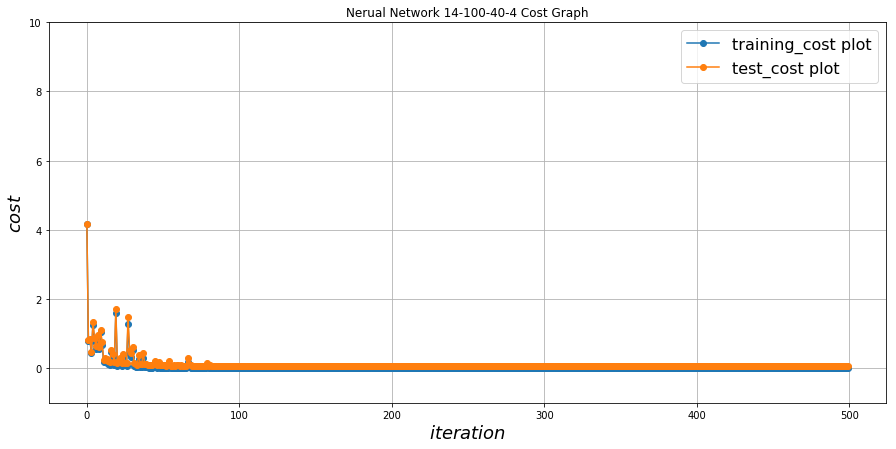

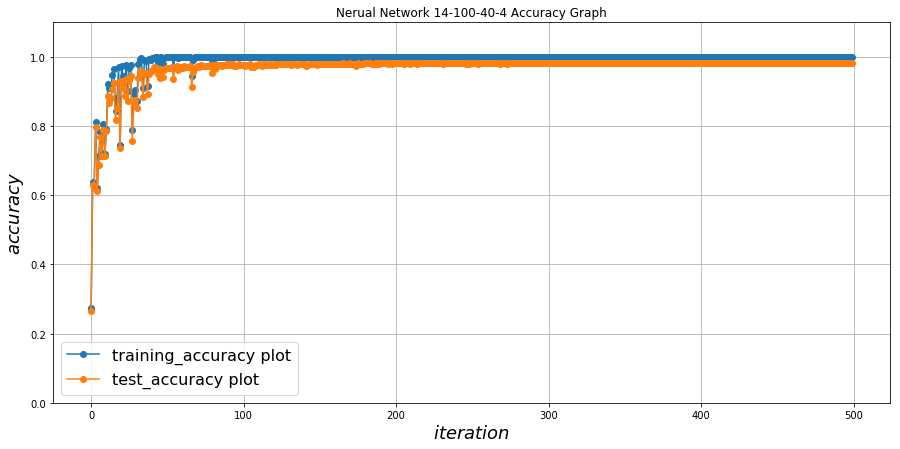

In [17]:
cost_title = 'Nerual Network 14-100-40-4 Cost Graph'
accuracy_title = 'Nerual Network 14-100-40-4 Accuracy Graph'
plot_graph(cost_title, training_cost[:500], test_cost[:500], 500, 'training_cost plot', 'test_cost plot', '$iteration$', '$cost$',(-1,10))
plot_graph(accuracy_title, training_accuracy[:500], test_accuracy[:500], 500, 'training_accuracy plot', 'test_accuracy plot', '$iteration$', '$accuracy$',(0,1.1))